<a href="https://colab.research.google.com/github/alchem0x2A/.emacs.d/blob/master/HW2_ODE_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Open in Google Colab](https://colab.research.google.com/drive/1pfaC5tYwUbPofaC1vbXqaW4gIVjPwZiU#scrollTo=JhCfdfwpjYGb)
# Numerical analysis of the stiff ODE equation of HW2 Q1

This tutorial provides a simple benchmarking of the solution of stiff ODE in Hw2 Q1, or namely
$$
\frac{d^2 H}{d X^2} = H \sqrt{\left(1 + \left(\frac{d H}{d X}\right)^2\right)^3}
$$

It is norotious as an ivp ode, as the solution itself will never converge to 0 (though can be solved via bvp). This notebook trys to develop the optimal initial values that fulfills $H(X_{\rm max}) = 0$ and $dH/dx(X_{\rm max}) = 0$.

The next cell is the ode function framework using `scipy.integrate.solve_ivp`.


The helper functions `crossing` and `chg_sign` checks whether $H$ or $dH/dX$ has a 0-crossing point.



In [0]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numba import jit, njit

def odefun(t, y):
  h, dh = y
  # print(h, dh)
  dh1 = dh
  ddh1 = h * np.sqrt((1 + dh ** 2) ** 3)
  return np.vstack([dh1, ddh1])

def solve(y0, tmax=5, neval=128, method="RK45"):
  # print(tmax)
  sol = solve_ivp(odefun, 
                  t_span=[0, tmax],
                  t_eval=np.linspace(0, tmax, neval),
                  y0=y0,
                  events=[crossing, chg_sign],
                  method=method,
                  vectorized=True,
                  dense_output=True,
                  )
  return sol

def crossing(t, y):
  """A crossing zero event for y0
  """
  return y[0]

def chg_sign(t, y):
  """Change sign event for y1
  """
  return y[1]

## Target quantity for optimization

Next we create a function to get the point where $H(X) \to 0$ or $dH/dX(X) \to 0$.

Case 1: 
H crosses 0 at: 1.5824116099686787 and H is:  [ 0.         -0.34301523]
Case 2:
H crosses 0 at: 0.9451675253609839 and H is:  [ 6.42047582e-01 -4.16333634e-17]
10 loops, best of 3: 31.3 ms per loop


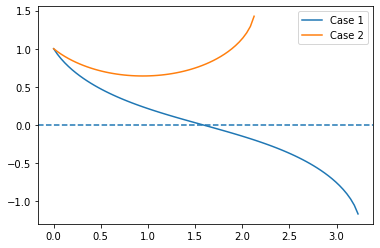

In [6]:
def get_min(y0, tmax=10):
  """Get the minimal value for y
  """
  sol = solve(y0, tmax=tmax)
  if len(sol.t_events[0]) > 0:
    t_min = sol.t_events[0][0]
    y_min = sol.sol(t_min)
  elif len(sol.t_events[1]) > 0:
    t_min = sol.t_events[1][0]
    y_min = sol.sol(t_min)
  else:
    t_min = 0
    y_min = [np.inf, np.inf]
  return t_min, y_min

# Case where H -> 0
t_min, y_min = get_min([1, -2])
print("Case 1: \nH crosses 0 at:", t_min, 
      "and H is: ", y_min)

# Case where dH/dX -> 0
t_min, y_min = get_min([1, -1])
print("Case 2:\nH crosses 0 at:", t_min, 
      "and H is: ", y_min)

# Profiling
%timeit get_min([1, -1])

# Plot the profiles
sol1 = solve([1, -2])
sol2 = solve([1, -1])

plt.plot(sol1.t, sol1.y[0], label="Case 1")
plt.plot(sol2.t, sol2.y[0], label="Case 2")
plt.axhline(y=0, ls="--")
plt.legend()


The target is to get the value $X_{\rm max}$ as high as possible. We can do a simple parameter screening to achieve this:

Possible solution for y0 is near: 0.7619047619047619


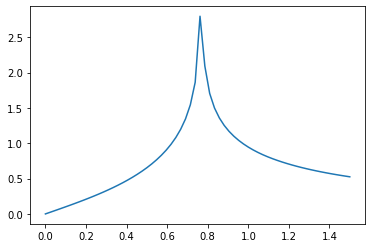

In [7]:
y1 = -1
y0s = np.linspace(0.0, 1.5, 64)
tm = np.array([get_min([y_, y1])[0] for y_ in y0s])
print("Possible solution for y0 is near:", y0s[tm.argmax()])
plt.plot(y0s, tm)

## Likelihood of $H(0), dH/dX(0)$
 To get the most possible $H0, dH/dX(0)$ values, we can use a 2D plot for the likelihood (here just the linear relation of $X_{\rm max}$). The brightest region of the output figure resembles that of the numerical solution made by shooting method.

Text(0.5, 1.0, 'Likelihood $X_{\\mathrm{max}}$')

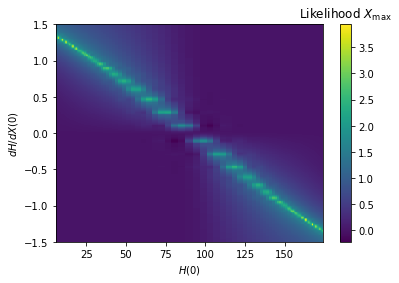

In [92]:
from scipy.interpolate import RectBivariateSpline
from pathlib import Path
# Change N to larger numbers if you want finer mesh
N = 100
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, N), 
                     np.linspace(-10, 10, N), indexing="ij")

f_res = Path("res_zz_{:d}.npy".format(N))
if not f_res.is_file():


  zz = np.empty_like(xx) # t-value
  for i in range(N):
    for j in range(N):
      t_min, y_min = get_min(y0=[xx[i, j], yy[i, j]])
      zz[i, j] = t_min
  # Save to file
  np.save(f_res, zz)
else:
  zz = np.load(f_res, allow_pickle=True)

# Bivariate smoothing plot
sps = RectBivariateSpline(xx[:, 0], yy[0, :], zz)
N_smooth = max(256, 2 * N)
xx_smooth, yy_smooth = np.meshgrid(np.linspace(xx.min(), xx.max(), N_smooth), 
                                   np.linspace(yy.min(), yy.max(), N_smooth), indexing="ij")


zz_smooth = sps(xx_smooth[:, 0], yy_smooth[0, :])
# zz_1 = calculate(xx, yy)

plt.figure(0)
plt.pcolor(90 + np.degrees(np.arctan(yy_smooth)), xx_smooth, zz_smooth)
#plt.pcolor(xx_smooth, yy_smooth, zz_smooth)
plt.xlabel("$H(0)$")
plt.ylabel("$dH/dX(0)$")
cb = plt.colorbar()
cb.ax.set_title("Likelihood $X_{\\mathrm{max}}$")


# Optimization test

In this part we will the $X_{\rm max}$ value as benchmarking for the performance of different multivariate minimizers.

Let's first try to minimize $-X_{\rm max}$ for a certain $dH/dX(0)$ and ranging $H(0)$. Let's try 3 methods in `scipy.optimize`

- Scalar function optimization
- (Multi)variable vector minimization
- Global minimization

## Testing scalar function min solver

In [56]:
# Testing scalar function `min y = f(x)`
from scipy.optimize import minimize_scalar
from time import perf_counter

avail_methods = ["Brent", "Golden"]
dhdx = -5
print("="*10, "Testing minimize_scalar methods", "="*10)
for method in avail_methods:
  t_ = perf_counter()
  res = minimize_scalar(lambda y: -get_min(y0=[y, dhdx])[0], method=method)
  print("Method {0:s}\tXmax {1:.2f}\tH0 {2:.5f}\t{3:.3f} s".format(method, -res.fun, 
                                                        res.x, perf_counter() - t_))

========== Testing minimize_scalar methods ==========
Method Brent	Xmax 9.13	H0 1.27253	0.750 s
Method Golden	Xmax 9.41	H0 1.27253	0.916 s


## Testing (multi)variable methods

In [61]:
# Testing function `min <y> = f(<x>, *param)`
from scipy.optimize import minimize
from time import perf_counter

avail_methods = ["Nelder-Mead",
                 "Powell" ,
                 "CG" ,
                 "BFGS" ,
                 "Newton-CG" ,
                 "L-BFGS-B" ,
                 "TNC" ,
                 "COBYLA" ,
                 "SLSQP" ,
                 "trust-constr",
                 "dogleg" ,
                 "trust-ncg" ,
                 "trust-exact" ,
                 "trust-krylov" ,]
dhdx = -5
print("="*10, "Testing minimize methods", "="*10)
for method in avail_methods:
  try:
    t_ = perf_counter()
    res = minimize(lambda y: -get_min(y0=[y, dhdx])[0], x0=1, method=method)
    if res.success:
      print("Method {0:s}\tXmax {1:.2f}\tH0 {2}\t{3:.3f} s".format(method, -res.fun, 
                                                                   np.float(res.x), perf_counter() - t_))
    else:
      print("Method {0:s}\t FAILED because:".format(method), res.message)
  except Exception as e:
    # msg = e.message
    print("Method {0:s}\t FAILED because:".format(method), e)
  

========== Testing minimize methods ==========
Method Nelder-Mead	Xmax 10.00	H0 1.2725256730482226	1.358 s
Method Powell	Xmax 10.00	H0 1.2725256730478918	2.790 s
Method CG	 FAILED because: Desired error not necessarily achieved due to precision loss.
Method BFGS	 FAILED because: Desired error not necessarily achieved due to precision loss.
Method Newton-CG	 FAILED because: Jacobian is required for Newton-CG method
Method L-BFGS-B	 FAILED because: b'ABNORMAL_TERMINATION_IN_LNSRCH'
Method TNC	 FAILED because: Linear search failed
Method COBYLA	Xmax 4.59	H0 1.2726609375	0.712 s
Method SLSQP	Xmax 7.77	H0 1.2725254368980237	1.221 s
Method trust-constr	Xmax 8.98	H0 1.2725256495713202	2.906 s
Method dogleg	 FAILED because: Jacobian is required for dogleg minimization
Method trust-ncg	 FAILED because: Jacobian is required for Newton-CG trust-region minimization
Method trust-exact	 FAILED because: Jacobian is required for trust region exact minimization.
Method trust-krylov	 FAILED because: ('J

As can be seen, the downhill simplex method ("Nelder-Mead") and the Powell's conjugate direction method work best. These methods are well-suited when no gradient information are needed. Constrained minimization methods `COBYLA` `SLSQP` and `trust-constr` work less stable. 

`CG` and `BFGS` methods surprisingly fails, possibly due to the lack of gradient information give to the function. Maybe works better for multivariable surface?

All other methods need gradient as input so cannot be used.

## Testing global optimization methods

In [69]:
# Testing global min function `min <y> = f(<x>, *param)`
from scipy import optimize
from time import perf_counter

avail_methods = ["differential_evolution", 
                 "shgo", "dual_annealing"]

dhdx = -5
print("="*10, "Testing global min methods", "="*10)

fmin = lambda y: -get_min(y0=[y, dhdx])[0]

for method in avail_methods:
  solver = getattr(optimize, method)
  if method == "basinhopping":
    params = dict(x0=1)
  else:
    params = dict(bounds=[(0.5, 1.5)])
  try:
    t_ = perf_counter()
    res = solver(fmin, **params)
    if res.success:
      print("Method {0:s}\tXmax {1:.2f}\tH0 {2}\t{3:.3f} s".format(method, -res.fun, 
                                                        np.float(res.x), 
                                                        perf_counter() - t_))
    else:
      print("Method {0:s}\t FAILED because:".format(method), res.message)
  except Exception as e:
    # msg = e.message
    print("Method {0:s}\t FAILED because:".format(method), e)

========== Testing global min methods ==========
Method differential_evolution	Xmax 9.97	H0 1.2725256674560983	8.613 s
Method shgo	Xmax 9.91	H0 1.2725256670665996	1.235 s
Method dual_annealing	Xmax 9.88	H0 1.2725256768374116	71.727 s


As can be seen, all the global optimization methods can produce the correct results but quite inefficient compared with the local optimization algorithms.

# The "Correct" Method: BVP

The stiffness of the ODE as an ivp is that numerical solutions of $dH/dX$ is not guaranteed to maintain the same sign, which in turn causes the solution to bump instead of converging to 0 when $X \to \infty$.

To enforce the solution to take $dH/dX = 0$, we need to code the problem as BVP. The follow codes considers the same `odefun` (of course, using $X$ instead of $t$), while providing Dirichlet BC at $X = 0$ and Neuman at $X = X_{\rm max}$

========== Tesing of D-N boundary conditions ==========
========== Tesing of N-N boundary conditions ==========
========== Tesing of D-D boundary conditions ==========


Text(0.5, 1.0, 'D-D boundary')

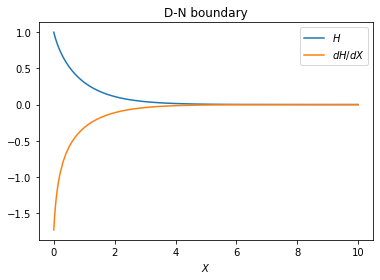

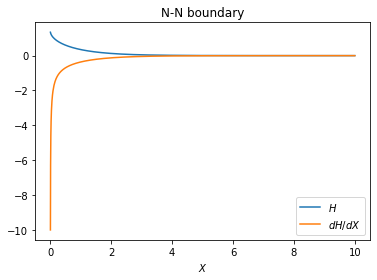

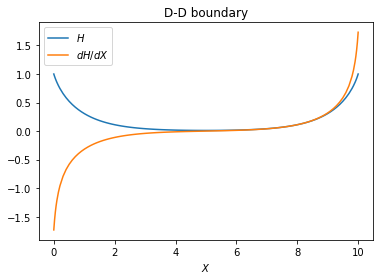

In [87]:
from scipy.integrate import solve_bvp

def bcfun(ya, yb, type=("d", "n"), p=(1, 0)):
  """d --> Dirichlet
     n --> Neuman
  """
  which = dict(d=0, n=1)
  res_a = ya[which[type[0]]] - p[0] # H or dHdX
  res_b = yb[which[type[1]]] - p[1] # H or dHdX
  return np.array([res_a, res_b])

def bvp_profile(xmax=10, N=100, type=("d", "n"), p=(1, 0)):
  """Need dHdX?
  """
  sol = solve_bvp(odefun, lambda ya, yb: bcfun(ya, yb, type, p),
                  x=np.linspace(0, xmax, N),
                  y=np.zeros((2, N)))
  return sol

print("="*10, "Tesing of D-N boundary conditions", "="*10)
sol = bvp_profile(10, 100)
plt.figure()
plt.plot(sol.x, sol.y[0], label="$H$")
plt.plot(sol.x, sol.y[1], label="$dH/dX$")
plt.xlabel("$X$")
plt.legend()
plt.title("D-N boundary")

print("="*10, "Tesing of N-N boundary conditions", "="*10)
plt.figure()
sol = bvp_profile(10, 100, type=("n", "n"), p=(-10, 0))
plt.plot(sol.x, sol.y[0], label="$H$")
plt.plot(sol.x, sol.y[1], label="$dH/dX$")
plt.xlabel("$X$")
plt.legend()
plt.title("N-N boundary")

print("="*10, "Tesing of D-D boundary conditions", "="*10)
plt.figure()
sol = bvp_profile(10, 100, type=("d", "d"), p=(1, 1))
plt.plot(sol.x, sol.y[0], label="$H$")
plt.plot(sol.x, sol.y[1], label="$dH/dX$")
plt.xlabel("$X$")
plt.legend()
plt.title("D-D boundary")

As can be seen, the boundary layer feature can be correctly captured. Additionally, let's calculate the $\theta - H(0)$ relation in the original question

[-5.67128182e+00 -5.14455402e+00 -4.70463011e+00 -4.33147587e+00
 -4.01078093e+00 -3.73205081e+00 -3.48741444e+00 -3.27085262e+00
 -3.07768354e+00 -2.90421088e+00 -2.74747742e+00 -2.60508906e+00
 -2.47508685e+00 -2.35585237e+00 -2.24603677e+00 -2.14450692e+00
 -2.05030384e+00 -1.96261051e+00 -1.88072647e+00 -1.80404776e+00
 -1.73205081e+00 -1.66427948e+00 -1.60033453e+00 -1.53986496e+00
 -1.48256097e+00 -1.42814801e+00 -1.37638192e+00 -1.32704482e+00
 -1.27994163e+00 -1.23489716e+00 -1.19175359e+00 -1.15036841e+00
 -1.11061251e+00 -1.07236871e+00 -1.03553031e+00 -1.00000000e+00
 -9.65688775e-01 -9.32515086e-01 -9.00404044e-01 -8.69286738e-01
 -8.39099631e-01 -8.09784033e-01 -7.81285627e-01 -7.53554050e-01
 -7.26542528e-01 -7.00207538e-01 -6.74508517e-01 -6.49407593e-01
 -6.24869352e-01 -6.00860619e-01 -5.77350269e-01 -5.54309051e-01
 -5.31709432e-01 -5.09525449e-01 -4.87732589e-01 -4.66307658e-01
 -4.45228685e-01 -4.24474816e-01 -4.04026226e-01 -3.83864035e-01
 -3.63970234e-01 -3.44327

Text(0, 0.5, '$H(0)$')

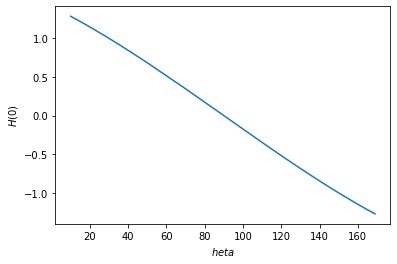

In [90]:
thetas = np.arange(10, 170)
dHdX0s = -1 / np.tan(np.radians(thetas))
print(dHdX0s)
H0s = np.empty_like(dHdX0s)
for i in range(len(dHdX0s)):
  dhdx0 = dHdX0s[i]
  sol = bvp_profile(10, 100, type=("n", "n"), p=(dhdx0, 0))
  H0s[i] = sol.y[0, 0]
plt.plot(thetas, H0s)
plt.xlabel("$\theta$")
plt.ylabel("$H(0)$")
